In [1]:
import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
HEIGHT = 137
WIDTH = 236
SIZE = 224

DATA_PATH = Path('/home/lextoumbourou/bengaliai-cv19/data')

TRAIN = [DATA_PATH/'bengaliai-cv19/train_image_data_0.parquet',
         DATA_PATH/'bengaliai-cv19/train_image_data_1.parquet',
         DATA_PATH/'bengaliai-cv19/train_image_data_2.parquet',
         DATA_PATH/'bengaliai-cv19/train_image_data_3.parquet']

OUT_TRAIN = DATA_PATH/'224x224'

In [3]:
OUT_TRAIN.mkdir()

In [4]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    import pdb; pdb.set_trace()
    return img #cv2.resize(img,(size,size))

In [5]:
%%time

df = pd.read_parquet(TRAIN[0])

CPU times: user 1min 30s, sys: 1.67 s, total: 1min 32s
Wall time: 1min 33s


In [6]:
img0 = df.iloc[0, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)

In [7]:
img0.shape

(137, 236)

In [8]:
img0[0]

array([254, 253, 252, 253, 251, 252, 253, 251, 251, 253, 254, 253, 253,
       253, 254, 253, 252, 253, 253, 253, 253, 252, 252, 253, 253, 252,
       252, 253, 252, 252, 252, 253, 254, 253, 253, 252, 252, 252, 253,
       252, 251, 252, 252, 251, 252, 251, 251, 251, 251, 252, 252, 252,
       252, 251, 252, 252, 252, 253, 252, 251, 253, 253, 252, 252, 253,
       253, 252, 251, 250, 249, 251, 252, 252, 251, 252, 252, 253, 253,
       252, 252, 251, 253, 252, 251, 251, 252, 253, 253, 251, 249, 251,
       253, 252, 253, 253, 252, 252, 251, 250, 250, 251, 253, 254, 254,
       253, 252, 251, 252, 254, 253, 252, 253, 253, 254, 253, 253, 255,
       255, 254, 252, 251, 251, 250, 252, 251, 250, 252, 250, 249, 252,
       249, 247, 249, 245, 240, 232, 208, 165, 125, 103,  94,  76,  58,
        56,  59,  64,  73,  78,  96, 127, 157, 180, 203, 220, 230, 240,
       245, 247, 247, 250, 251, 252, 252, 252, 252, 252, 253, 252, 251,
       252, 252, 252, 253, 253, 252, 253, 253, 253, 253, 254, 25

In [9]:
255 - img0[0]

array([  1,   2,   3,   2,   4,   3,   2,   4,   4,   2,   1,   2,   2,
         2,   1,   2,   3,   2,   2,   2,   2,   3,   3,   2,   2,   3,
         3,   2,   3,   3,   3,   2,   1,   2,   2,   3,   3,   3,   2,
         3,   4,   3,   3,   4,   3,   4,   4,   4,   4,   3,   3,   3,
         3,   4,   3,   3,   3,   2,   3,   4,   2,   2,   3,   3,   2,
         2,   3,   4,   5,   6,   4,   3,   3,   4,   3,   3,   2,   2,
         3,   3,   4,   2,   3,   4,   4,   3,   2,   2,   4,   6,   4,
         2,   3,   2,   2,   3,   3,   4,   5,   5,   4,   2,   1,   1,
         2,   3,   4,   3,   1,   2,   3,   2,   2,   1,   2,   2,   0,
         0,   1,   3,   4,   4,   5,   3,   4,   5,   3,   5,   6,   3,
         6,   8,   6,  10,  15,  23,  47,  90, 130, 152, 161, 179, 197,
       199, 196, 191, 182, 177, 159, 128,  98,  75,  52,  35,  25,  15,
        10,   8,   8,   5,   4,   3,   3,   3,   3,   3,   2,   3,   4,
         3,   3,   3,   2,   2,   3,   2,   2,   2,   2,   1,   

In [10]:
img0.max()

255

In [11]:
img0 = 255 - img0[0]
img_norm = (img0*(255.0/img0.max())).astype(np.uint8)

In [12]:
img_norm

array([  1,   2,   3,   2,   5,   3,   2,   5,   5,   2,   1,   2,   2,
         2,   1,   2,   3,   2,   2,   2,   2,   3,   3,   2,   2,   3,
         3,   2,   3,   3,   3,   2,   1,   2,   2,   3,   3,   3,   2,
         3,   5,   3,   3,   5,   3,   5,   5,   5,   5,   3,   3,   3,
         3,   5,   3,   3,   3,   2,   3,   5,   2,   2,   3,   3,   2,
         2,   3,   5,   6,   7,   5,   3,   3,   5,   3,   3,   2,   2,
         3,   3,   5,   2,   3,   5,   5,   3,   2,   2,   5,   7,   5,
         2,   3,   2,   2,   3,   3,   5,   6,   6,   5,   2,   1,   1,
         2,   3,   5,   3,   1,   2,   3,   2,   2,   1,   2,   2,   0,
         0,   1,   3,   5,   5,   6,   3,   5,   6,   3,   6,   7,   3,
         7,  10,   7,  12,  19,  29,  60, 115, 166, 194, 206, 229, 252,
       255, 251, 244, 233, 226, 203, 164, 125,  96,  66,  44,  32,  19,
        12,  10,  10,   6,   5,   3,   3,   3,   3,   3,   2,   3,   5,
         3,   3,   3,   2,   2,   3,   2,   2,   2,   2,   1,   

In [13]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax


def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin, ymax, xmin, xmax = bbox(img0[5:-5, 5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax, xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin, ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

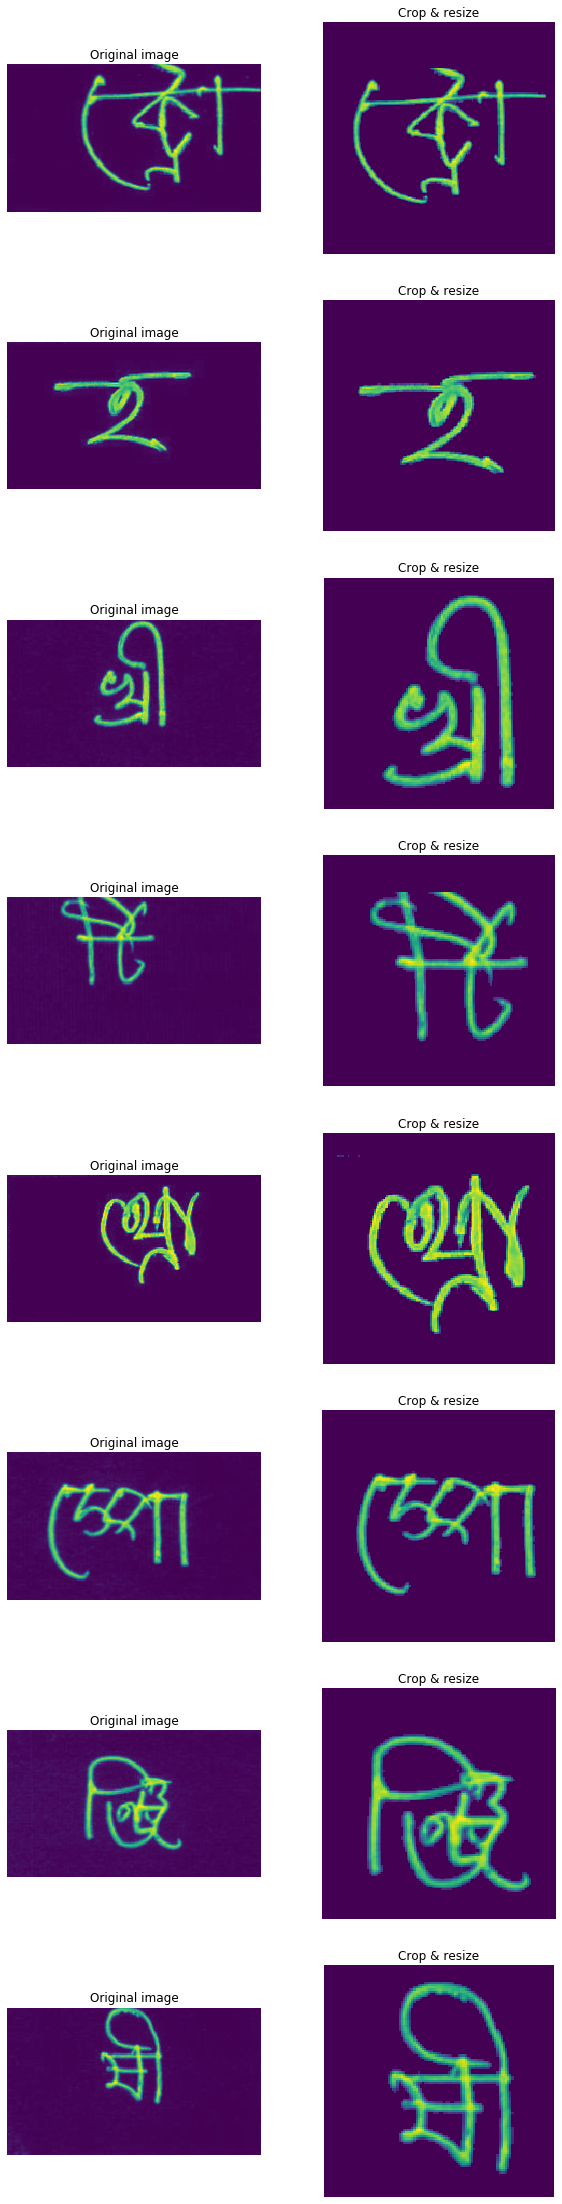

In [14]:
n_imgs = 8
fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

for idx in tqdm(range(n_imgs)):
    #somehow the original input is inverted
    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img)

    axs[idx,0].imshow(img0)
    axs[idx,0].set_title('Original image')
    axs[idx,0].axis('off')
    axs[idx,1].imshow(img)
    axs[idx,1].set_title('Crop & resize')
    axs[idx,1].axis('off')

plt.show()

In [15]:
x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN/'train.zip', 'w') as img_out:
    for fname in tqdm(TRAIN):
        df = pd.read_parquet(fname)
        #the input is inverted
        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
        for idx in tqdm(range(len(df))):
            name = df.iloc[idx,0]
            #normalize each image by its max val
            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
            img = crop_resize(img)
        
            x_tot.append((img/255.0).mean())
            x2_tot.append(((img/255.0)**2).mean()) 
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(name + '.png', img)

In [16]:
#image stats
img_avr =  np.array(x_tot).mean()
img_std =  np.sqrt(np.array(x2_tot).mean() - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

mean: 0.06928534252950991 , std: 0.2090492878995984
